In [1]:
# Deep Learning Quick Reference Chapter 5: Multiclass Classification
# Mike Bernico <mike.bernico@gmail.com>

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_mnist():
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    #shape(train_X) #50000 X 28 X 28
    
    #평탄화(flatten)
    train_X = train_X.reshape(-1, 784)
    test_X = test_X.reshape(-1, 784)
    
    # standardScaler 사용할 필요없음(0 - 255 사이에 모두 있으므로)
    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X /= 255
    test_X /= 255

    #종속변수벡터(dependent variable vectors) -> 범주형 벡터로 전환
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    
    #train, val으로 dataset 분리
    return {"train_X": train_X[:55000, :], "train_y": train_y[:55000, :],
            "val_X": train_X[55000:, :], "val_y": train_y[55000:, :], "test_X": test_X, "test_y": test_y}

In [3]:
def build_network(input_features=None):
    # first we specify an input layer, with a shape == features
    inputs = Input(shape=(input_features,), name="input") # 784
    x = Dense(512, activation='relu', name="hidden1")(inputs)
    x = Dense(256, activation='relu', name="hidden2")(x)
    x = Dense(128, activation='relu', name="hidden3")(x)
    prediction = Dense(10, activation='softmax', name="output")(x) #출력
    model = Model(inputs=inputs, outputs=prediction)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [4]:
def create_callbacks():
    tensorboard_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), "tb_log", "mnist_512_256_128"), histogram_freq=1, batch_size=32,
                                       write_graph=True, write_grads=False)
    #ROC AUC callback사용치 않음(이진 분류에서 효과, 다중분류에서 명료하게 정의되지 않음)
    checkpoint_callback = ModelCheckpoint(filepath="./model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", monitor='val_accuracy', #val_acc
                                          verbose=0, save_best_only=True)
    return [tensorboard_callback, checkpoint_callback]

In [5]:
def print_model_metrics(model, data):
    #모델 평가하기(test data)
    loss, accuracy = model.evaluate(x=data["test_X"], y=data["test_y"])
    print("\n model test loss is "+str(loss)+" accuracy is "+str(accuracy))
    
    #김태영 모델평가하기
    #loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32)
    #print(loss_and_metrics)  ==> [0.02206190561465919, 0.992900013923645]
    
    # 정밀도, 재현율, f1 값 
    y_softmax = model.predict(data["test_X"]) # batch_size=32 # this is an n x class matrix of probabilities
    y_hat = y_softmax.argmax(axis=-1)  # this will be the class number.
    test_y = data["test_y"].argmax(axis=-1)  # our test data is also categorical
    print(classification_report(test_y, y_hat))
    
    # 영상입력 다중분류 모델사용하기(실제손글씨 판정결과 plt)   <======   model.add(Dense(10, activation='softmax'))
    width = 28
    height = 28
    plt_row = 5
    plt_col = 5
    plt.rcParams["figure.figsize"] = (10,10)
    f, axarr = plt.subplots(plt_row, plt_col)
    cnt = 0
    i = 0
    j = []
    while cnt < (plt_row*plt_col):
        if np.argmax(data["test_y"][i]) == np.argmax(y_softmax[i]):
            i += 1
            continue
        sub_plt = axarr[cnt//plt_row, cnt%plt_col]
        sub_plt.axis('off')
        sub_plt.imshow(data["test_X"][i].reshape(width, height))
        sub_plt_title = 'R: ' + str(np.argmax(data["test_y"][i])) + ' P: ' + str(np.argmax(y_softmax[i]))
        sub_plt.set_title(sub_plt_title)
        j.append(i)

        i += 1    
        cnt += 1

    print(f'\ntest {len(y_softmax)}중에서 틀린 개수 : {cnt}')
    print(f'틀린 index : {j}')

    plt.show()
    

In [6]:
# 영상입력 이진분류 모델사용하기(실제손글씨 odd even으로 판정결과  plt)  <=====   model.add(Dense(1, activation='sigmoid'))
#     plt_row = 5
#     plt_col = 5
#     plt.rcParams["figure.figsize"] = (10,10)
#     f, axarr = plt.subplots(plt_row, plt_col)
#     for i in range(plt_row*plt_col):
#         sub_plt = axarr[i//plt_row, i%plt_col]
#         sub_plt.axis('off')
#         sub_plt.imshow(data["test_X"][i].reshape(width, height)) #x_test
#         sub_plt_title = 'R: '
#         if data["test_y"][i] :  #y_test
#             sub_plt_title += 'odd '
#         else:
#             sub_plt_title += 'even '
#         sub_plt_title += 'P: '
#         if y_softmax[i] >= 0.5 : #yhat_test
#             sub_plt_title += 'odd '
#         else:
#             sub_plt_title += 'even '        
#         sub_plt.set_title(sub_plt_title)
#     plt.show()    

In [7]:
# 모델 학습과정 살펴보기(김태영 영상입력이진분류(CNN) ====> tensorboard 이용가능
 # 4. 모델 학습시키기
 # hist = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))

# 모델 load하는 방법 에러남  from keras.models import load_model
# hist=load_model("/tf/keraspark/Deep-Learning-Quick-Reference-master/Chapter05/model-weights.46-0.987400.hdf5")
 # =====> AttributeError: 'Model' object has no attribute 'history'
def plt_model_process(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 0.5])
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylim([0.8, 1.0])
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    plt.show()    

In [8]:
# def main():
#     data = load_mnist() #딕셔너리로 리턴 
#     callbacks = create_callbacks()
#     model = build_network(data["train_X"].shape[1]) #( , 784)
#     hist=model.fit(x=data["train_X"], y=data["train_y"],
#               batch_size=30,
#               epochs=50, #50
#               validation_data=(data["val_X"], data["val_y"]),
#               verbose=1,
#               callbacks=callbacks)

#     print_model_metrics(model, data)
    
#     #김태영 모델학습과정 plt  ===> tensorboard 기능있음
#     plt_model_process(hist) # model로 매개변수처리하면 error 또한 return hist해도 error

# if __name__ == "__main__":
#     main()

In [9]:
data = load_mnist() #딕셔너리로 리턴 
callbacks = create_callbacks()
model = build_network(data["train_X"].shape[1]) #( , 784)
hist=model.fit(x=data["train_X"], y=data["train_y"],
          batch_size=30,
          epochs=10, #50
          validation_data=(data["val_X"], data["val_y"]),
          verbose=1,
          callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 16s 295us/step - loss: 0.2056 - accuracy: 0.9369 - val_loss: 0.1146 - val_accuracy: 0.9668
Epoch 2/10
55000/55000 [==============================] - 15s 269us/step - loss: 0.0919 - accuracy: 0.9723 - val_loss: 0.0837 - val_accuracy: 0.9764
Epoch 3/10
55000/55000 [==============================] - 15s 278us/step - loss: 0.0660 - accuracy: 0.9799 - val_loss: 0.0746 - val_accuracy: 0.9800
Epoch 4/10
55000/55000 [==============================] - 15s 280us/step - loss: 0.0503 - accuracy: 0.9845 - val_loss: 0.0741 - val_accuracy: 0.9796
Epoch 5/10
55000/55000 [==============================] - 16s 285us/step - loss: 0.0408 - accuracy: 0.9871 - val_loss: 0.0839 - val_accuracy: 0.9786
Epoch 6/10
55000/55000 [==============================] - 15s 279us/step - loss: 0.0356 - accuracy: 0.9887 - val_loss: 0.0792 - val_accuracy: 0.9820
Epoch 7/10
55000/55000 [==============================] -

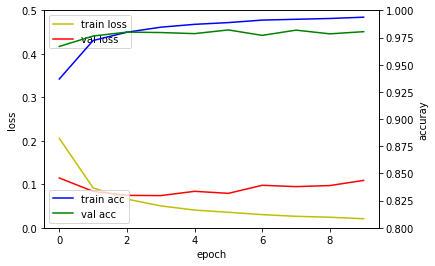

In [10]:
#김태영 모델학습과정 plt  ===> tensorboard 기능있음
plt_model_process(hist) # model로 매개변수처리하면 error 또한 return hist해도 error

10000/10000 [==============================] - 1s 105us/step

 model test loss is 0.10339189805095703 accuracy is 0.9768999814987183
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.96      0.97       982
           5       0.97      0.98      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.95      0.97       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


test 10000중에서 틀린 개수 : 25
틀린 index : [104, 115, 149, 151, 232, 247, 321, 340, 358, 381, 399, 495, 582, 610, 

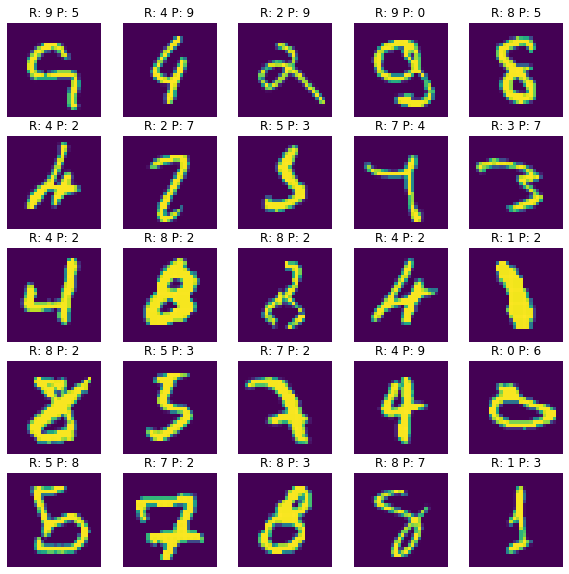

In [11]:
print_model_metrics(model, data)